<a href="https://colab.research.google.com/github/kareemullah123456789/CNN-AI/blob/main/CNN_CaseStudy_SkinLesion_HAM10000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Case Study: Skin Lesion Classification (HAM10000 - Multi-Class)

**Goal:** Learn how to build a multi-class CNN classifier using a real-world medical imaging dataset with 7 skin lesion types.

This notebook builds on the Chest X-Ray notebook but introduces **key new concepts**:
- **Multi-class classification** (7 classes instead of 2)
- **Labels from a CSV file** (not from folder names)
- **Softmax activation** (not sigmoid)
- **Categorical crossentropy** (not binary crossentropy)
- **Extreme class imbalance** (one class has 60x more images than another)

---

**Dataset:** [HAM10000](https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000) from Kaggle
- ~10,015 dermatoscopic images of skin lesions
- 7 diagnostic classes
- Images are 600x450 pixels, RGB
- Labels are in a CSV file (`HAM10000_metadata.csv`)

---

### The 7 Classes

| Abbreviation | Full Name | Type |
|---|---|---|
| **nv** | Melanocytic nevi | Benign (mole) |
| **mel** | Melanoma | **Malignant (cancer)** |
| **bkl** | Benign keratosis | Benign |
| **bcc** | Basal cell carcinoma | **Malignant (cancer)** |
| **akiec** | Actinic keratoses | Pre-cancerous |
| **vasc** | Vascular lesions | Benign |
| **df** | Dermatofibroma | Benign |

---

### Table of Contents

1. Setup: Mount Google Drive & Imports
2. Explore Dataset Structure
3. Load & Explore Metadata CSV
4. Map Image IDs to File Paths
5. Load, Resize & Normalize Images
6. Encode Labels (String → Integer)
7. Train / Validation / Test Split
8. Visualize Samples from Each Class
9. Class Imbalance Analysis & Class Weights
10. Data Augmentation
11. Model 1: Baseline CNN
12. Model 2: Improved CNN (BN + Dropout + Augmentation + Class Weights)
13. Training History Comparison
14. Confusion Matrix & Classification Report
15. Per-Class Accuracy Analysis
16. Error Analysis
17. Conclusion

---

### How to Get the Dataset

1. Go to [Kaggle: HAM10000](https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000)
2. Click **Download** (you need a free Kaggle account)
3. You will get a zip file containing:
   - `HAM10000_metadata.csv` — labels and metadata
   - `HAM10000_images_part_1/` — first batch of images (~5,000)
   - `HAM10000_images_part_2/` — second batch of images (~5,000)
4. Upload the zip to Google Drive as `ham10000.zip`

Expected structure after extraction:
```
MyDrive/
  ham10000_data/
    HAM10000_metadata.csv
    HAM10000_images_part_1/    (~5,000 .jpg images)
    HAM10000_images_part_2/    (~5,000 .jpg images)
```

## 1. Setup: Mount Google Drive & Imports

In [3]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
import zipfile

# ============================================================
# Download HAM10000 dataset from Kaggle and store on Google Drive
# ============================================================
# FIRST TIME SETUP:
#   1. Go to https://www.kaggle.com/settings -> API -> Create New Token
#   2. This downloads a file called 'kaggle.json'
#   3. Upload it when prompted below
# ============================================================

# Step 1: Install kaggle package
!pip install -q kaggle

# Step 2: Upload your kaggle.json API key
from google.colab import files
import json

kaggle_dir = os.path.expanduser('~/.kaggle')
kaggle_json = os.path.join(kaggle_dir, 'kaggle.json')

if not os.path.exists(kaggle_json):
    print('Upload your kaggle.json file (from https://www.kaggle.com/settings -> API):')
    uploaded = files.upload()    # opens file picker in Colab
    os.makedirs(kaggle_dir, exist_ok=True)
    # Save uploaded file to ~/.kaggle/kaggle.json
    for filename in uploaded:
        with open(kaggle_json, 'wb') as f:
            f.write(uploaded[filename])
    # Set permissions (required by kaggle API)
    !chmod 600 ~/.kaggle/kaggle.json
    print('kaggle.json saved!')
else:
    print('kaggle.json already exists, skipping upload.')

# Step 3: Download the dataset to Google Drive
extract_path = '/content/drive/MyDrive/ham10000_data'

if not os.path.exists(extract_path):
    os.makedirs(extract_path, exist_ok=True)
    print('Downloading HAM10000 dataset from Kaggle...')
    print('This may take a few minutes (~2.7 GB)...')

    # Download dataset zip files to the extract_path
    !kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p "{extract_path}"

    # Step 4: Unzip all downloaded zip files
    print('\nExtracting zip files...')
    for filename in os.listdir(extract_path):
        if filename.endswith('.zip'):
            zip_file = os.path.join(extract_path, filename)
            print(f'  Extracting: {filename}')
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
            # Remove the zip file after extraction to save space
            os.remove(zip_file)
            print(f'  Removed: {filename} (zip no longer needed)')

    print('\nDownload and extraction complete!')
else:
    print(f'Dataset already exists at: {extract_path}')
    print('Delete the folder and re-run this cell to re-download.')

# Show what we have
print(f'\nDataset contents:')
for item in sorted(os.listdir(extract_path)):
    item_path = os.path.join(extract_path, item)
    if os.path.isdir(item_path):
        print(f'  [FOLDER] {item}/ -> {len(os.listdir(item_path))} files')
    else:
        size_mb = os.path.getsize(item_path) / 1024 / 1024
        print(f'  [FILE]   {item} ({size_mb:.1f} MB)')

Upload your kaggle.json file (from https://www.kaggle.com/settings -> API):


Saving kaggle.json to kaggle.json
kaggle.json saved!
Dataset already exists at: /content/drive/MyDrive/ham10000_data
Delete the folder and re-run this cell to re-download.

Dataset contents:
  [FOLDER] HAM10000_images_part_1/ -> 5000 files
  [FOLDER] HAM10000_images_part_2/ -> 5015 files
  [FILE]   HAM10000_metadata.csv (0.5 MB)
  [FOLDER] ham10000_images_part_1/ -> 5000 files
  [FOLDER] ham10000_images_part_2/ -> 5015 files
  [FILE]   hmnist_28_28_L.csv (29.4 MB)
  [FILE]   hmnist_28_28_RGB.csv (87.6 MB)
  [FILE]   hmnist_8_8_L.csv (2.4 MB)
  [FILE]   hmnist_8_8_RGB.csv (7.2 MB)


In [7]:
import os
import numpy as np
import pandas as pd                                # CSV handling
import matplotlib.pyplot as plt
import cv2                                         # image loading and resizing
from PIL import Image                              # image validation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

print(f'TensorFlow version: {tf.__version__}')
print(f'GPU available: {len(tf.config.list_physical_devices("GPU")) > 0}')

TensorFlow version: 2.19.0
GPU available: True


## 2. Explore Dataset Structure

Unlike the Chest X-Ray dataset (where labels came from folder names), the HAM10000 dataset uses a **CSV file** to store labels.

This is a very common pattern in real-world datasets:
- All images are dumped into one or more folders
- A separate CSV/JSON file maps each image filename to its label
- The CSV may also contain extra metadata (age, sex, body location, etc.)

In [8]:
# -----------------------------------------------------------
# Set the base path to the extracted dataset
# Adjust this path based on what was printed above
# -----------------------------------------------------------
base_path = '/content/drive/MyDrive/ham10000_data'

# List all files and folders at the top level
print('Dataset contents:')
print('=' * 55)
for item in sorted(os.listdir(base_path)):
    item_path = os.path.join(base_path, item)

    if os.path.isdir(item_path):
        # Count files inside the folder
        file_count = len(os.listdir(item_path))
        print(f'  [FOLDER] {item}/ -> {file_count} files')
    else:
        # Show file size
        size_kb = os.path.getsize(item_path) / 1024
        print(f'  [FILE]   {item} ({size_kb:.1f} KB)')

Dataset contents:
  [FOLDER] HAM10000_images_part_1/ -> 5000 files
  [FOLDER] HAM10000_images_part_2/ -> 5015 files
  [FILE]   HAM10000_metadata.csv (550.1 KB)
  [FOLDER] ham10000_images_part_1/ -> 5000 files
  [FOLDER] ham10000_images_part_2/ -> 5015 files
  [FILE]   hmnist_28_28_L.csv (30085.9 KB)
  [FILE]   hmnist_28_28_RGB.csv (89668.3 KB)
  [FILE]   hmnist_8_8_L.csv (2478.3 KB)
  [FILE]   hmnist_8_8_RGB.csv (7348.6 KB)


In [9]:
# ============================================================
# SPEED OPTIMIZATION: Load dataset to LOCAL disk (not Drive)
# ============================================================
# Strategy: Kaggle download is fast (~2-3 min on Colab's network)
# We download/extract directly to local /content/ SSD.
# Google Drive is only used to cache the zip for future sessions.
# ============================================================
import zipfile

local_path = '/content/ham10000_local'
drive_zip = '/content/drive/MyDrive/ham10000_data/skin-cancer-mnist-ham10000.zip'

if os.path.exists(local_path) and len(os.listdir(local_path)) > 0:
    print(f'Local data already exists at {local_path} — skipping download.')

elif os.path.exists(drive_zip):
    # Zip cached on Drive from a previous session — extract to local
    print('Found cached zip on Google Drive. Extracting to local disk...')
    os.makedirs(local_path, exist_ok=True)
    with zipfile.ZipFile(drive_zip, 'r') as zf:
        zf.extractall(local_path)
    print('Done!')

else:
    # Fresh download from Kaggle directly to local disk (fastest)
    print('Downloading from Kaggle directly to local disk...')
    print('This takes ~2-3 minutes on Colab network...')
    os.makedirs(local_path, exist_ok=True)
    !kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p /content/

    local_zip = '/content/skin-cancer-mnist-ham10000.zip'
    print('Extracting...')
    with zipfile.ZipFile(local_zip, 'r') as zf:
        zf.extractall(local_path)

    # Cache zip to Drive for future sessions
    print('Caching zip to Google Drive for next session...')
    os.makedirs(os.path.dirname(drive_zip), exist_ok=True)
    !cp "{local_zip}" "{drive_zip}" &
    os.remove(local_zip)
    print('Done!')

# Update base_path to local
base_path = local_path
print(f'\nUsing fast local path: {base_path}')

This takes ~2-3 minutes on Colab network...
Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.19G/5.20G [02:46<00:00, 31.0MB/s]
100% 5.20G/5.20G [02:47<00:00, 33.4MB/s]
Extracting...
Caching zip to Google Drive for next session...
Done!

Using fast local path: /content/ham10000_local


## 3. Load & Explore Metadata CSV

The CSV file `HAM10000_metadata.csv` contains one row per image with these columns:
- `image_id` — filename (without .jpg extension)
- `dx` — diagnosis (the label: nv, mel, bkl, bcc, akiec, vasc, df)
- `dx_type` — how the diagnosis was confirmed
- `age` — patient age
- `sex` — patient sex
- `localization` — body location of the lesion

In [10]:
# -----------------------------------------------------------
# Load the metadata CSV
# -----------------------------------------------------------


csv_path = os.path.join(base_path, 'HAM10000_metadata.csv')
metadata = pd.read_csv(csv_path)

print(f'Metadata shape: {metadata.shape[0]} rows x {metadata.shape[1]} columns')
print(f'\nColumn names: {list(metadata.columns)}')
print(f'\nFirst 5 rows:')
metadata.head()

Metadata shape: 10015 rows x 7 columns

Column names: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']

First 5 rows:


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [11]:
# -----------------------------------------------------------
# Understand the label column: 'dx' (diagnosis)
# -----------------------------------------------------------
print('Unique diagnosis classes:')
print('=' * 45)

# Count how many images per class
class_counts = metadata['dx'].value_counts()
print(class_counts)

print(f'\nTotal images: {len(metadata)}')
print(f'Number of classes: {metadata["dx"].nunique()}')

Unique diagnosis classes:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

Total images: 10015
Number of classes: 7


In [12]:
# -----------------------------------------------------------
# Quick look at other metadata columns
# -----------------------------------------------------------
print('Age distribution:')
print(f'  Min: {metadata["age"].min()}, Max: {metadata["age"].max()}, '
      f'Mean: {metadata["age"].mean():.1f}')
print(f'  Missing: {metadata["age"].isna().sum()}')

print(f'\nSex distribution:')
print(metadata['sex'].value_counts().to_string())

print(f'\nDiagnosis method (dx_type):')
print(metadata['dx_type'].value_counts().to_string())

Age distribution:
  Min: 0.0, Max: 85.0, Mean: 51.9
  Missing: 57

Sex distribution:
sex
male       5406
female     4552
unknown      57

Diagnosis method (dx_type):
dx_type
histo        5340
follow_up    3704
consensus     902
confocal       69


## 4. Map Image IDs to File Paths

The CSV has `image_id` (e.g., `ISIC_0024306`) but images are stored as `ISIC_0024306.jpg` in two separate folders.

We need to:
1. Build a dictionary mapping image_id → full file path
2. Search both `HAM10000_images_part_1/` and `HAM10000_images_part_2/`
3. Verify every CSV entry has a matching image file

In [14]:
# -----------------------------------------------------------
# Build a lookup: image_id -> full file path
# -----------------------------------------------------------
image_id_to_path = {}   # dictionary: 'ISIC_0024306' -> '/content/.../ISIC_0024306.jpg'

# Search in both image folders
image_folders = [
    os.path.join(base_path, 'HAM10000_images_part_1'),
    os.path.join(base_path, 'HAM10000_images_part_2'),
]

for folder in image_folders:
    # Skip if folder does not exist
    if not os.path.isdir(folder):
        print(f'  WARNING: Folder not found: {folder}')
        continue

    # Loop through every file in the folder
    for filename in os.listdir(folder):
        # Skip hidden files
        if filename.startswith('.'):
            continue

        # Remove .jpg extension to get the image_id
        # 'ISIC_0024306.jpg' -> 'ISIC_0024306'
        image_id = os.path.splitext(filename)[0]

        # Store the full path
        full_path = os.path.join(folder, filename)
        image_id_to_path[image_id] = full_path

print(f'Found {len(image_id_to_path)} image files on disk')
print(f'CSV has {len(metadata)} entries')

# -----------------------------------------------------------
# Check: does every CSV row have a matching image file?
# -----------------------------------------------------------
missing_count = 0
for i in range(len(metadata)):
    img_id = metadata.iloc[i]['image_id']
    if img_id not in image_id_to_path:
        missing_count += 1

if missing_count == 0:
    print('All CSV entries have matching image files!')
else:
    print(f'WARNING: {missing_count} CSV entries have no matching image file')

Found 10015 image files on disk
CSV has 10015 entries
All CSV entries have matching image files!


## 5. Load, Resize & Normalize Images

The original images are 600×450 pixels — too large for training on Colab.
We resize to **64×64** to keep memory manageable (~10,000 images × 64×64×3 × 4 bytes = ~470 MB).

**Why 64×64 instead of 150×150?**
- HAM10000 has ~10,000 images (almost 2× more than X-Ray)
- At 150×150 it would use ~4 GB RAM — risky on Colab free tier
- 64×64 is sufficient for this classification task
- You can increase to 128×128 if you have Colab Pro

In [15]:
# -----------------------------------------------------------
# Load images with multithreading (FAST — 8 parallel threads)
# -----------------------------------------------------------
from concurrent.futures import ThreadPoolExecutor

IMG_SIZE = 64    # 64x64 keeps memory manageable on free Colab

def load_single_image(args):
    """Load, convert, and resize a single image."""
    file_path, label = args
    img = cv2.imread(file_path)
    if img is None:
        return None, None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img, label

# -----------------------------------------------------------
# Build list of (path, label) pairs from metadata
# -----------------------------------------------------------
load_tasks = []
for i in range(len(metadata)):
    row = metadata.iloc[i]
    image_id = row['image_id']
    label = row['dx']
    if image_id in image_id_to_path:
        load_tasks.append((image_id_to_path[image_id], label))

# -----------------------------------------------------------
# Optional: Use a subset for quick demo on free Colab
# Set to None to use ALL images, or a number like 3000
# -----------------------------------------------------------
SAMPLE_SIZE = None    # Change to 3000 for a quick demo run

if SAMPLE_SIZE is not None and SAMPLE_SIZE < len(load_tasks):
    np.random.seed(42)
    indices = np.random.choice(len(load_tasks), size=SAMPLE_SIZE, replace=False)
    load_tasks = [load_tasks[i] for i in indices]
    print(f'Using SAMPLE of {SAMPLE_SIZE} images (out of {len(metadata)})')
else:
    print(f'Using ALL {len(load_tasks)} images')

# Load with 8 threads (I/O-bound task, so threading helps a lot)
images = []
labels = []
skipped = 0
total = len(load_tasks)

print(f'Loading {total} images with 8 threads...')
with ThreadPoolExecutor(max_workers=8) as executor:
    results = executor.map(load_single_image, load_tasks)
    for idx, (img, label) in enumerate(results):
        if img is None:
            skipped += 1
        else:
            images.append(img)
            labels.append(label)
        if (idx + 1) % 2000 == 0 or (idx + 1) == total:
            print(f'  Loaded {idx + 1}/{total} images...')

images = np.array(images, dtype=np.float32)
labels = np.array(labels)

print(f'\nDataset loaded:')
print(f'  Shape:   {images.shape}')
print(f'  Labels:  {labels.shape}')
print(f'  Memory:  {images.nbytes / 1024 / 1024:.1f} MB')
print(f'  Skipped: {skipped} images')
print(f'  Pixels:  [{images.min():.0f}, {images.max():.0f}]')

Using ALL 10015 images
Loading 10015 images with 8 threads...
  Loaded 2000/10015 images...
  Loaded 4000/10015 images...
  Loaded 6000/10015 images...
  Loaded 8000/10015 images...
  Loaded 10000/10015 images...
  Loaded 10015/10015 images...

Dataset loaded:
  Shape:   (10015, 64, 64, 3)
  Labels:  (10015,)
  Memory:  469.5 MB
  Skipped: 0 images
  Pixels:  [0, 255]


In [16]:
# -----------------------------------------------------------
# Normalize: [0, 255] -> [0.0, 1.0]
# -----------------------------------------------------------
images = images / 255.0

print(f'After normalization:')
print(f'  Pixel range: [{images.min():.2f}, {images.max():.2f}]')
print(f'  Mean pixel:  {images.mean():.4f}')
print(f'  Std pixel:   {images.std():.4f}')

After normalization:
  Pixel range: [0.00, 1.00]
  Mean pixel:  0.6263
  Std pixel:   0.1829


## 6. Encode Labels (String → Integer)

**Key difference from X-Ray notebook:**
- X-Ray had 2 classes → **binary** classification → `sigmoid` + `binary_crossentropy`
- HAM10000 has 7 classes → **multi-class** classification → `softmax` + `sparse_categorical_crossentropy`

**Label encoding options for multi-class:**

| Method | Label Format | Loss Function |
|--------|-------------|---------------|
| Integer labels | `[0, 3, 5, 1, ...]` | `sparse_categorical_crossentropy` |
| One-hot labels | `[[1,0,0,...], [0,0,0,1,...]]` | `categorical_crossentropy` |

We use **integer labels** with `sparse_categorical_crossentropy` — it is simpler and uses less memory.

In [17]:
# -----------------------------------------------------------
# Define class names and create string -> integer mapping
# -----------------------------------------------------------
class_names = sorted(np.unique(labels).tolist())
num_classes = len(class_names)

print(f'Classes found: {class_names}')
print(f'Number of classes: {num_classes}')

# Create mapping: class name -> integer index
# Example: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
class_to_idx = {}
for i in range(num_classes):
    class_to_idx[class_names[i]] = i

print(f'\nLabel mapping:')
for name, idx in class_to_idx.items():
    print(f'  {name:8s} -> {idx}')

Classes found: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Number of classes: 7

Label mapping:
  akiec    -> 0
  bcc      -> 1
  bkl      -> 2
  df       -> 3
  mel      -> 4
  nv       -> 5
  vasc     -> 6


In [18]:
# -----------------------------------------------------------
# Convert string labels to integer labels
# 'nv' -> 5, 'mel' -> 4, etc.
# -----------------------------------------------------------
int_labels = np.zeros(len(labels), dtype=np.int32)

for i in range(len(labels)):
    int_labels[i] = class_to_idx[labels[i]]

print(f'Label conversion done:')
print(f'  Original (string): {labels[:5]}')
print(f'  Encoded (integer): {int_labels[:5]}')
print(f'\nClass counts after encoding:')
for idx in range(num_classes):
    count = int((int_labels == idx).sum())
    print(f'  {class_names[idx]:8s} ({idx}): {count:5d} images')

Label conversion done:
  Original (string): ['bkl' 'bkl' 'bkl' 'bkl' 'bkl']
  Encoded (integer): [2 2 2 2 2]

Class counts after encoding:
  akiec    (0):   327 images
  bcc      (1):   514 images
  bkl      (2):  1099 images
  df       (3):   115 images
  mel      (4):  1113 images
  nv       (5):  6705 images
  vasc     (6):   142 images


## 7. Train / Validation / Test Split

Same strategy as X-Ray: **70% / 15% / 15%** with **stratified** splitting.

Stratification is even MORE important here because some classes have very few images (df: ~115).
Without `stratify`, a random split could put ALL 115 df images in the training set and ZERO in test.

In [19]:
# -----------------------------------------------------------
# Step 1: Split 70% train vs 30% temp
# -----------------------------------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    images, int_labels,
    test_size=0.30,
    random_state=42,
    stratify=int_labels       # keep class ratios in each split
)

# -----------------------------------------------------------
# Step 2: Split the 30% into 15% val + 15% test
# -----------------------------------------------------------
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

# Free memory
images = None
int_labels = None
X_temp = None
y_temp = None

print('Split results:')
print(f'  Train:      {X_train.shape[0]:5d} images')
print(f'  Validation: {X_val.shape[0]:5d} images')
print(f'  Test:       {X_test.shape[0]:5d} images')

# Show class distribution in training set
print(f'\nTraining set class counts:')
for idx in range(num_classes):
    count = int((y_train == idx).sum())
    print(f'  {class_names[idx]:8s}: {count}')

Split results:
  Train:       7010 images
  Validation:  1502 images
  Test:        1503 images

Training set class counts:
  akiec   : 229
  bcc     : 360
  bkl     : 769
  df      : 81
  mel     : 779
  nv      : 4693
  vasc    : 99


## 8. Visualize Samples from Each Class

With 7 classes, it is especially important to visualize examples to understand:
- What each class looks like
- How different the classes are from each other
- Some classes look very similar — this makes the task hard!

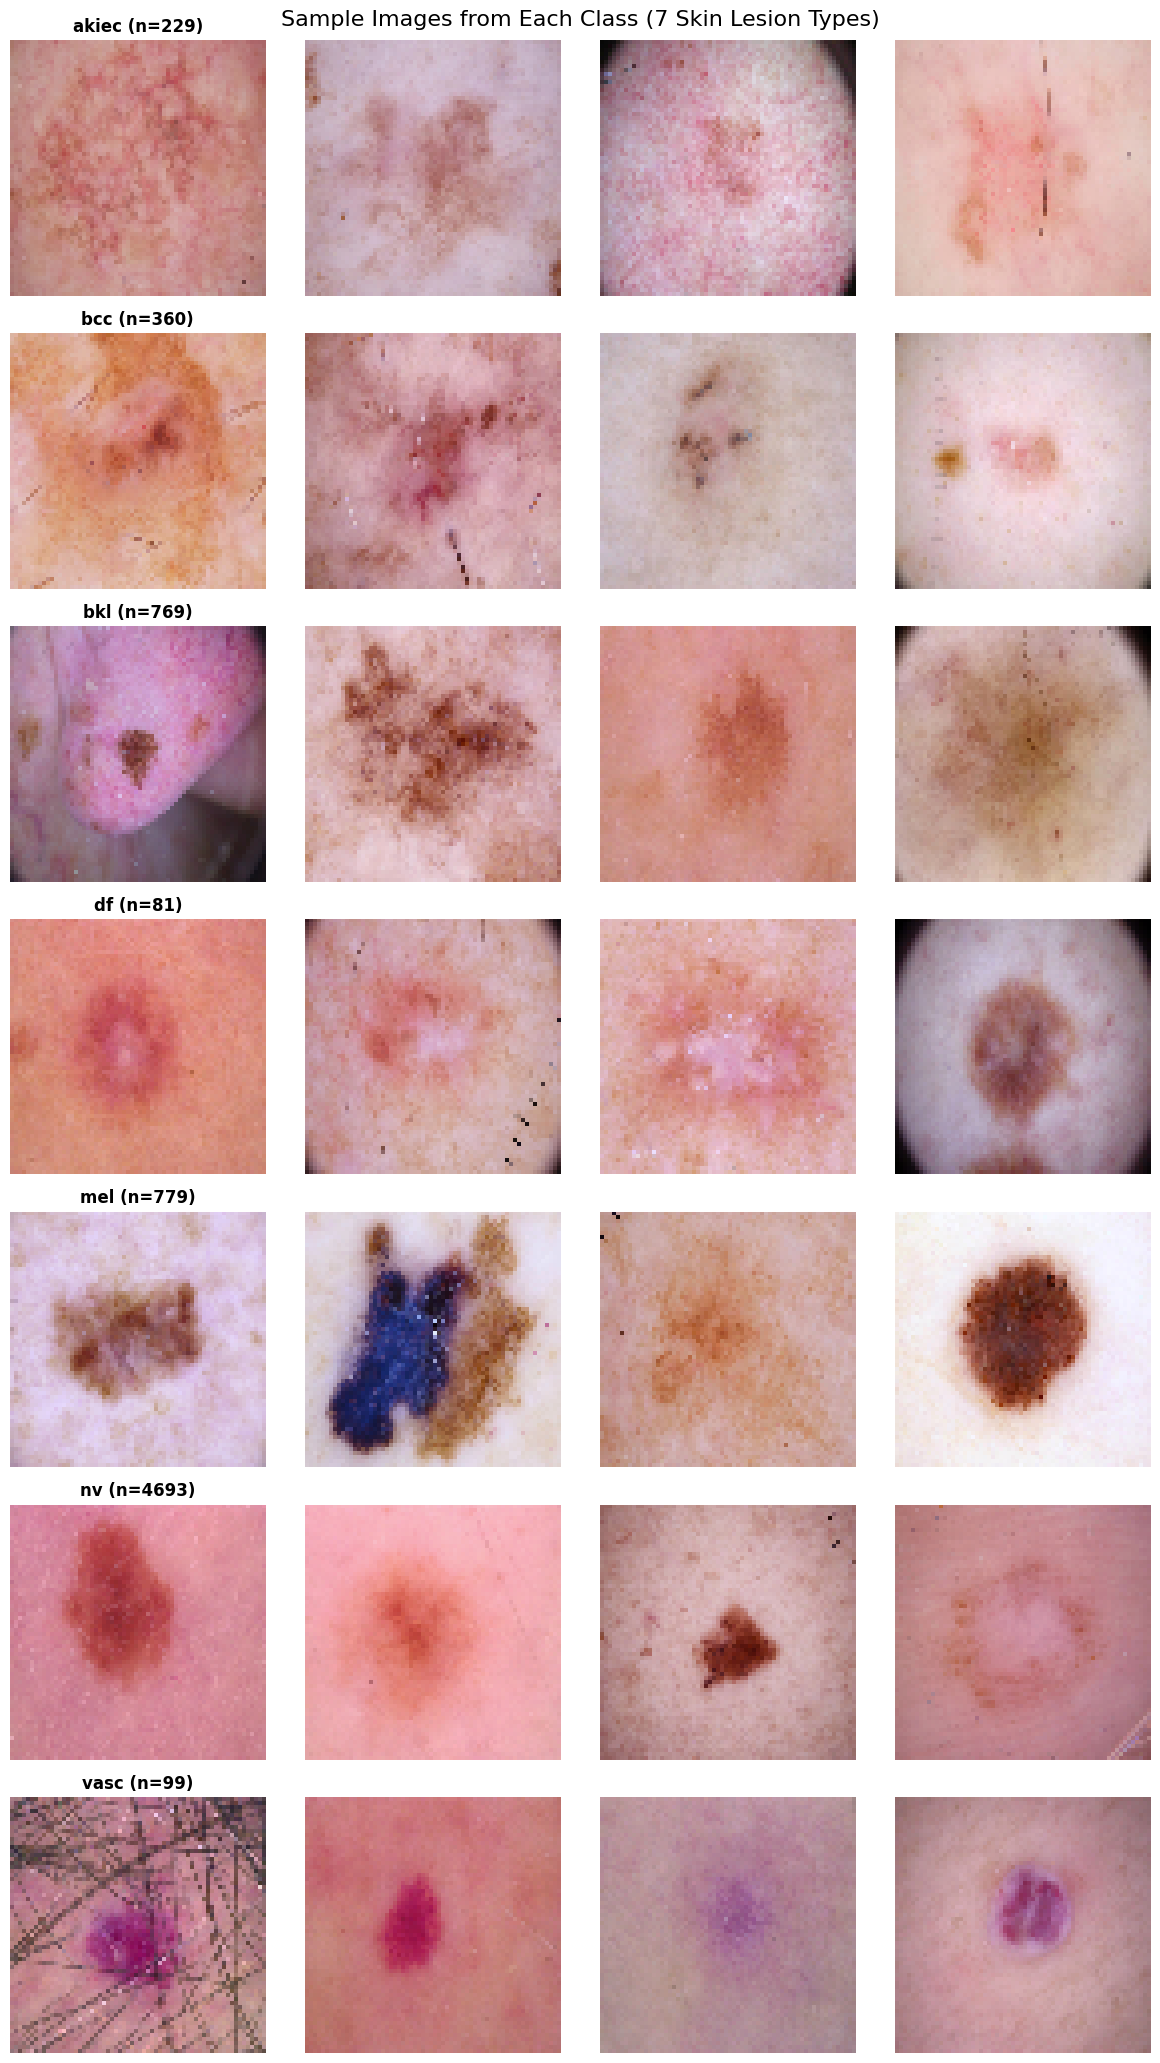

In [20]:
# -----------------------------------------------------------
# Display 4 random samples from each of the 7 classes
# -----------------------------------------------------------
fig, axes = plt.subplots(7, 4, figsize=(12, 21))

np.random.seed(42)

for row in range(7):
    # Get indices for this class
    class_idx = row
    matching = np.where(y_train == class_idx)[0]

    # Pick 4 random samples
    chosen = np.random.choice(matching, size=min(4, len(matching)), replace=False)

    for col in range(4):
        if col < len(chosen):
            axes[row, col].imshow(X_train[chosen[col]])
        axes[row, col].axis('off')

        # Label only the first column
        if col == 0:
            count = int((y_train == class_idx).sum())
            axes[row, col].set_title(
                f'{class_names[class_idx]} (n={count})',
                fontsize=12, fontweight='bold'
            )

plt.suptitle('Sample Images from Each Class (7 Skin Lesion Types)', fontsize=16)
plt.tight_layout()
plt.show()

## 9. Class Imbalance Analysis & Class Weights

HAM10000 has **extreme** class imbalance:
- `nv` (moles): ~6,700 images (67%)
- `df` (dermatofibroma): ~115 images (1.1%)
- That is a **~58:1 ratio!**

Without class weights, the model will learn to predict `nv` for everything and achieve ~67% accuracy while completely ignoring the 6 minority classes.

**Class weights** tell the loss function:
- Getting a `df` image wrong costs **much more** than getting an `nv` image wrong
- This forces the model to pay attention to rare classes too

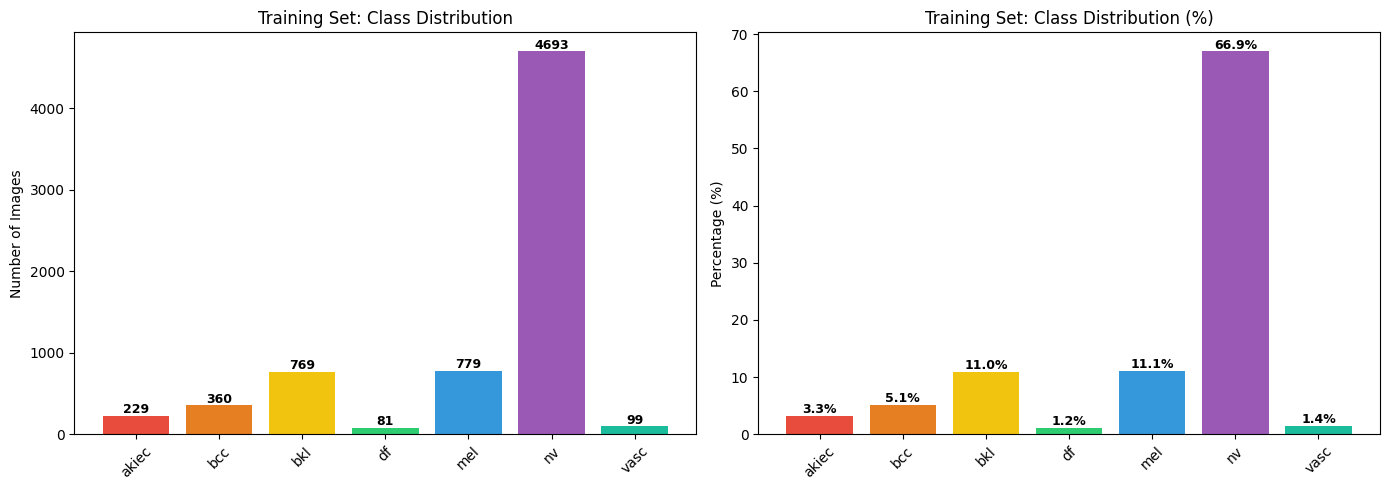


Most common class:  nv (4693 images)
Least common class: df (81 images)
Imbalance ratio: 57.9:1


In [21]:
# -----------------------------------------------------------
# Visualize class distribution
# -----------------------------------------------------------
train_counts = []
for idx in range(num_classes):
    train_counts.append(int((y_train == idx).sum()))

# Bar plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: raw counts
colors = ['#e74c3c', '#e67e22', '#f1c40f', '#2ecc71', '#3498db', '#9b59b6', '#1abc9c']
bars = axes[0].bar(class_names, train_counts, color=colors)
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Training Set: Class Distribution')
axes[0].tick_params(axis='x', rotation=45)

# Add count labels
for bar_idx in range(num_classes):
    axes[0].text(
        bars[bar_idx].get_x() + bars[bar_idx].get_width() / 2,
        bars[bar_idx].get_height() + 30,
        str(train_counts[bar_idx]),
        ha='center', fontsize=9, fontweight='bold'
    )

# Right: percentage
total = sum(train_counts)
percentages = [c / total * 100 for c in train_counts]
bars2 = axes[1].bar(class_names, percentages, color=colors)
axes[1].set_ylabel('Percentage (%)')
axes[1].set_title('Training Set: Class Distribution (%)')
axes[1].tick_params(axis='x', rotation=45)

for bar_idx in range(num_classes):
    axes[1].text(
        bars2[bar_idx].get_x() + bars2[bar_idx].get_width() / 2,
        bars2[bar_idx].get_height() + 0.5,
        f'{percentages[bar_idx]:.1f}%',
        ha='center', fontsize=9, fontweight='bold'
    )

plt.tight_layout()
plt.show()

# Print imbalance ratio
max_count = max(train_counts)
min_count = min(train_counts)
print(f'\nMost common class:  {class_names[train_counts.index(max_count)]} ({max_count} images)')
print(f'Least common class: {class_names[train_counts.index(min_count)]} ({min_count} images)')
print(f'Imbalance ratio: {max_count / min_count:.1f}:1')

In [22]:
# -----------------------------------------------------------
# Compute class weights
# Higher weight = minority class = bigger penalty for mistakes
# -----------------------------------------------------------
unique_classes = np.array(list(range(num_classes)))

weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train
)

# Convert to dictionary: {0: weight_0, 1: weight_1, ...}
class_weight_dict = {}
for i in range(num_classes):
    class_weight_dict[i] = weights[i]

print('Computed class weights:')
print('=' * 45)
for idx in range(num_classes):
    print(f'  {class_names[idx]:8s} ({idx}): weight = {weights[idx]:.4f}')

print(f'\nInterpretation:')
print(f'  High weight = rare class = model penalized MORE for mistakes')
print(f'  Low weight  = common class = model penalized LESS for mistakes')

Computed class weights:
  akiec    (0): weight = 4.3731
  bcc      (1): weight = 2.7817
  bkl      (2): weight = 1.3022
  df       (3): weight = 12.3633
  mel      (4): weight = 1.2855
  nv       (5): weight = 0.2134
  vasc     (6): weight = 10.1154

Interpretation:
  High weight = rare class = model penalized MORE for mistakes
  Low weight  = common class = model penalized LESS for mistakes


## 10. Data Augmentation

Same concept as X-Ray, but with one key difference:
- **`horizontal_flip=True`** — skin lesions can appear in any orientation, so flipping is valid
- **`vertical_flip=True`** — also valid for skin lesions (unlike X-rays where anatomy matters)

Augmentation is critical here because some classes have only ~80 training images.

In [23]:
# -----------------------------------------------------------
# Configure augmentation transforms
# -----------------------------------------------------------
train_datagen = ImageDataGenerator(
    rotation_range=20,           # rotate up to +/- 20 degrees
    width_shift_range=0.1,       # shift left/right up to 10%
    height_shift_range=0.1,      # shift up/down up to 10%
    zoom_range=0.15,             # zoom in/out up to 15%
    horizontal_flip=True,        # skin lesions can be flipped
    vertical_flip=True,          # skin lesions can be flipped vertically too
    fill_mode='nearest'
)

# Fit on training data
train_datagen.fit(X_train)

# Create batch generator
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=32
)

print(f'Augmentation configured')
print(f'Training images: {X_train.shape[0]}')
print(f'Batches per epoch: {X_train.shape[0] // 32}')

Augmentation configured
Training images: 7010
Batches per epoch: 219


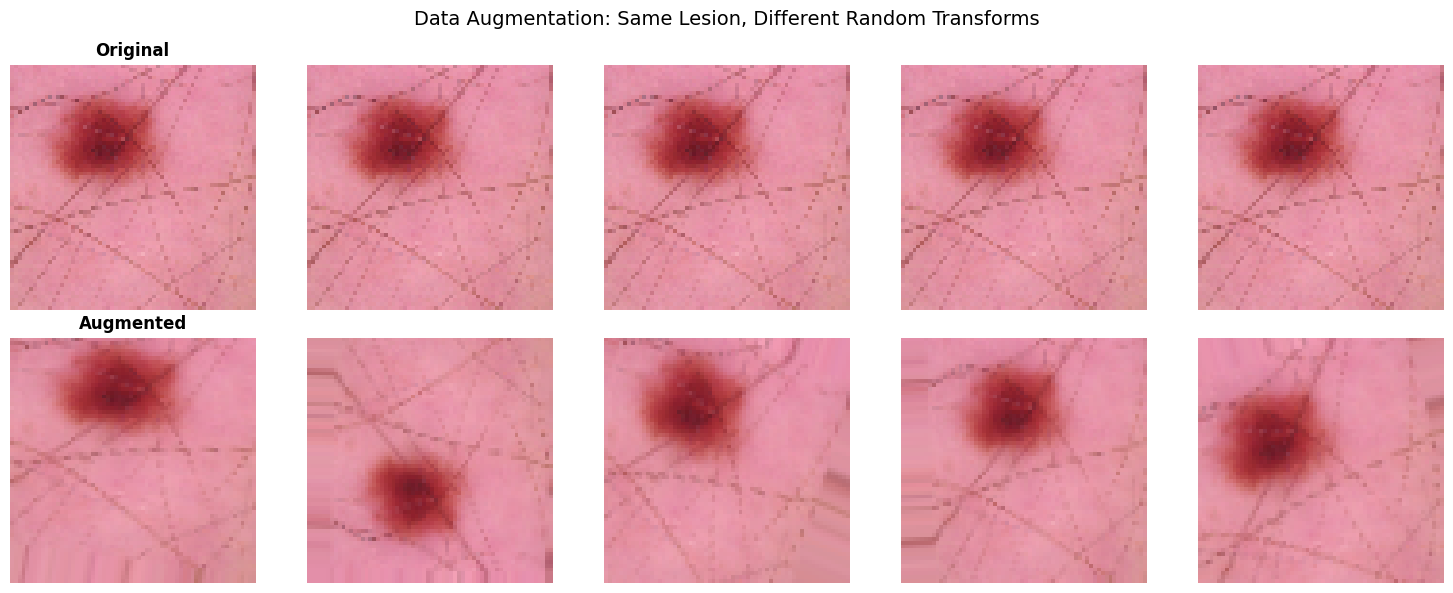

In [24]:
# -----------------------------------------------------------
# Visualize augmentation: original vs augmented
# -----------------------------------------------------------
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Top row: original image repeated
original_img = X_train[0]
for col in range(5):
    axes[0, col].imshow(original_img)
    axes[0, col].axis('off')
    if col == 0:
        axes[0, col].set_title('Original', fontsize=12, fontweight='bold')

# Bottom row: augmented versions
single_gen = train_datagen.flow(
    X_train[0:1], y_train[0:1],
    batch_size=1
)
for col in range(5):
    aug_batch = next(single_gen)
    axes[1, col].imshow(aug_batch[0][0])
    axes[1, col].axis('off')
    if col == 0:
        axes[1, col].set_title('Augmented', fontsize=12, fontweight='bold')

plt.suptitle('Data Augmentation: Same Lesion, Different Random Transforms', fontsize=14)
plt.tight_layout()
plt.show()

## 11. Model 1: Baseline CNN

Simple CNN with **NO regularization** to establish a reference.

**Key differences from X-Ray baseline:**
- Output layer: **7 neurons with softmax** (not 1 neuron with sigmoid)
- Loss: **`sparse_categorical_crossentropy`** (not binary_crossentropy)

**Why softmax?**
- Softmax outputs 7 probabilities that sum to 1.0
- Example: [0.01, 0.02, 0.05, 0.01, 0.11, 0.78, 0.02] → model thinks class 5 (nv) is most likely
- The predicted class = the index with highest probability (argmax)

In [25]:
# -----------------------------------------------------------
# Build baseline CNN for 7-class classification
# -----------------------------------------------------------
baseline_model = models.Sequential([
    # Block 1: 32 filters
    layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                  input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),        # 64 -> 32

    # Block 2: 64 filters
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),        # 32 -> 16

    # Block 3: 128 filters
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),        # 16 -> 8

    # Classifier head
    layers.Flatten(),                   # 8*8*128 = 8,192
    layers.Dense(128, activation='relu'),

    # OUTPUT: 7 neurons + softmax (one per class)
    layers.Dense(num_classes, activation='softmax')
])

# Compile with sparse_categorical_crossentropy
# 'sparse' means labels are integers [0,1,2,...6], not one-hot
baseline_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,855 (4.36 MB)

 Trainable params: 1,142,855 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# -----------------------------------------------------------
# Train baseline: no augmentation, no class weights
# -----------------------------------------------------------
baseline_history = baseline_model.fit(
    X_train, y_train,
    epochs=5,               # reduced from 20 for free Colab
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6829 - loss: 0.8941 - val_accuracy: 0.6831 - val_loss: 0.8716
Epoch 2/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6939 - loss: 0.8290 - val_accuracy: 0.7150 - val_loss: 0.8154
Epoch 3/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7169 - loss: 0.7491 - val_accuracy: 0.7157 - val_loss: 0.7991
Epoch 4/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7359 - loss: 0.7012 - val_accuracy: 0.7290 - val_loss: 0.8152
Epoch 5/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7309 - loss: 0.7202 - val_accuracy: 0.6585 - val_loss: 0.9172


## 12. Model 2: Improved CNN (BN + Dropout + Augmentation + Class Weights)

Same improvements as X-Ray notebook:
- **BatchNormalization** after every Conv2D
- **Dropout** after every block
- **Two Conv2D layers per block**
- **GlobalAveragePooling2D** instead of Flatten
- Training with **augmented data** and **class weights**
- **EarlyStopping + ReduceLROnPlateau**

Output is still **7 neurons + softmax**.

In [33]:
# -----------------------------------------------------------
# Build improved CNN with regularization
# -----------------------------------------------------------
improved_model = models.Sequential([
    # Block 1: 32 filters, two conv layers
    layers.Conv2D(32, (3, 3), padding='same',
                  input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),        # 64 -> 32
    layers.Dropout(0.25),

    # Block 2: 64 filters
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),        # 32 -> 16
    layers.Dropout(0.25),

    # Block 3: 128 filters
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),        # 16 -> 8
    layers.Dropout(0.25),

    # Classifier head
    layers.GlobalAveragePooling2D(),    # 8x8x128 -> 128
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    # OUTPUT: 7 classes + softmax
    layers.Dense(num_classes, activation='softmax')
])

improved_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

improved_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 16, 16, 128)    │             

 Total params: 306,215 (1.17 MB)

 Trainable params: 305,319 (1.16 MB)

 Non-trainable params: 896 (3.50 KB)

In [34]:
# -----------------------------------------------------------
# Callbacks
# -----------------------------------------------------------
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,               # reduced from 7 for faster stopping
    restore_best_weights=True
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# -----------------------------------------------------------
# Train with augmentation + class weights + callbacks
# -----------------------------------------------------------
improved_history = improved_model.fit(
    train_generator,
    steps_per_epoch=X_train.shape[0] // 32,
    epochs=5,               # reduced from 40 for free Colab
    validation_data=(X_val, y_val),
    callbacks=[early_stop, lr_scheduler],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 30s 89ms/step - accuracy: 0.3582 - loss: 1.8369 - val_accuracy: 0.0353 - val_loss: 2.7175 - learning_rate: 0.0010
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3438 - loss: 2.2502 - val_accuracy: 0.0333 - val_loss: 2.7307 - learning_rate: 0.0010
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.4187 - loss: 1.6757 - val_accuracy: 0.0826 - val_loss: 2.8197 - learning_rate: 0.0010
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3438 - loss: 1.4002 - val_accuracy: 0.0952 - val_loss: 2.7289 - learning_rate: 0.0010
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.4557 - loss: 1.5181 - val_accuracy: 0.4507 - val_loss: 1.4973 - learning_rate: 5.0000e-04


## 13. Training History Comparison

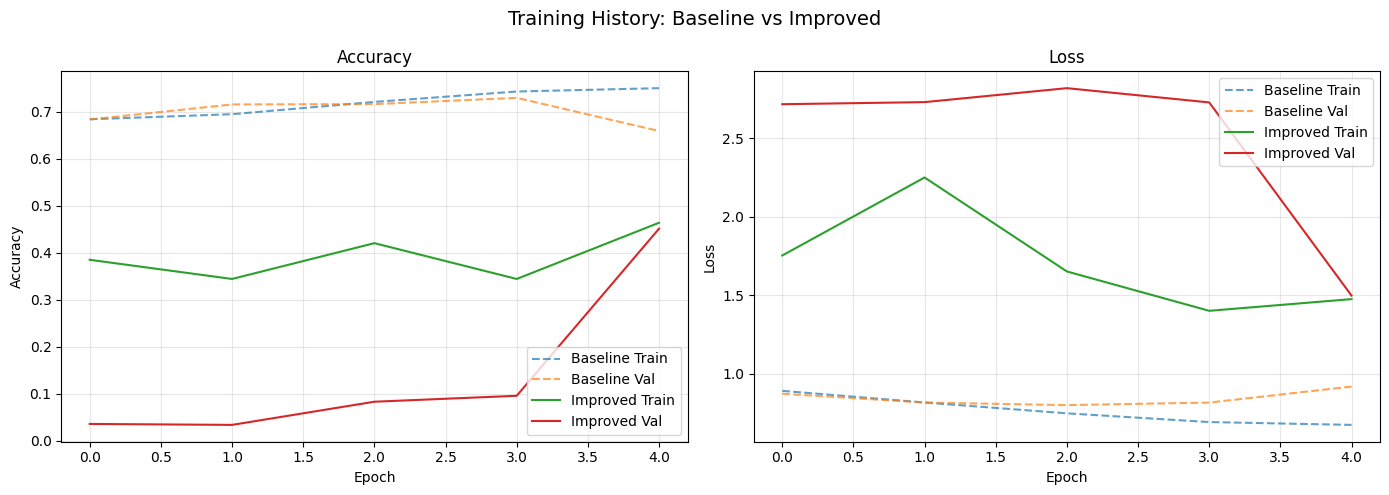

In [35]:
# -----------------------------------------------------------
# Plot accuracy and loss curves for both models
# -----------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Accuracy ---
axes[0].plot(baseline_history.history['accuracy'],
             label='Baseline Train', linestyle='--', alpha=0.7)
axes[0].plot(baseline_history.history['val_accuracy'],
             label='Baseline Val', linestyle='--', alpha=0.7)
axes[0].plot(improved_history.history['accuracy'],
             label='Improved Train')
axes[0].plot(improved_history.history['val_accuracy'],
             label='Improved Val')
axes[0].set_title('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# --- Loss ---
axes[1].plot(baseline_history.history['loss'],
             label='Baseline Train', linestyle='--', alpha=0.7)
axes[1].plot(baseline_history.history['val_loss'],
             label='Baseline Val', linestyle='--', alpha=0.7)
axes[1].plot(improved_history.history['loss'],
             label='Improved Train')
axes[1].plot(improved_history.history['val_loss'],
             label='Improved Val')
axes[1].set_title('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Training History: Baseline vs Improved', fontsize=14)
plt.tight_layout()
plt.show()

In [36]:
# -----------------------------------------------------------
# Test set evaluation
# -----------------------------------------------------------
print('Test Set Evaluation')
print('=' * 50)

baseline_loss, baseline_acc = baseline_model.evaluate(X_test, y_test, verbose=0)
print(f'  Baseline:  Loss = {baseline_loss:.4f}   Accuracy = {baseline_acc:.4f}')

improved_loss, improved_acc = improved_model.evaluate(X_test, y_test, verbose=0)
print(f'  Improved:  Loss = {improved_loss:.4f}   Accuracy = {improved_acc:.4f}')

print(f'\n  Improvement: {(improved_acc - baseline_acc) * 100:+.2f}% accuracy')

print(f'\nNote: With 7 classes, random guessing = {100/num_classes:.1f}% accuracy')
print(f'      Always predicting nv (majority) = ~67% accuracy')
print(f'      So accuracy above 70% means the model is learning real patterns.')

Test Set Evaluation
  Baseline:  Loss = 0.9528   Accuracy = 0.6507
  Improved:  Loss = 1.5010   Accuracy = 0.4358

  Improvement: -21.49% accuracy

Note: With 7 classes, random guessing = 14.3% accuracy
      Always predicting nv (majority) = ~67% accuracy
      So accuracy above 70% means the model is learning real patterns.


## 14. Confusion Matrix & Classification Report

For multi-class problems, the confusion matrix is **7×7** instead of 2×2.

Reading a multi-class confusion matrix:
- **Rows** = true class
- **Columns** = predicted class
- **Diagonal** = correct predictions
- **Off-diagonal** = mistakes (which class was confused with which)

In [37]:
# -----------------------------------------------------------
# Get predictions from improved model
# Softmax outputs 7 probabilities per image
# We take argmax to get the predicted class index
# -----------------------------------------------------------
y_pred_probs = improved_model.predict(X_test, verbose=0)   # shape: (N, 7)
y_pred = np.argmax(y_pred_probs, axis=1)                   # shape: (N,)

print(f'Prediction example (first image):')
print(f'  Probabilities: {y_pred_probs[0]}')
print(f'  Predicted class: {y_pred[0]} ({class_names[y_pred[0]]})')
print(f'  True class:      {y_test[0]} ({class_names[y_test[0]]})')

Prediction example (first image):
  Probabilities: [0.09213816 0.13319495 0.40157294 0.08504675 0.13679531 0.09885582
 0.05239608]
  Predicted class: 2 (bkl)
  True class:      2 (bkl)


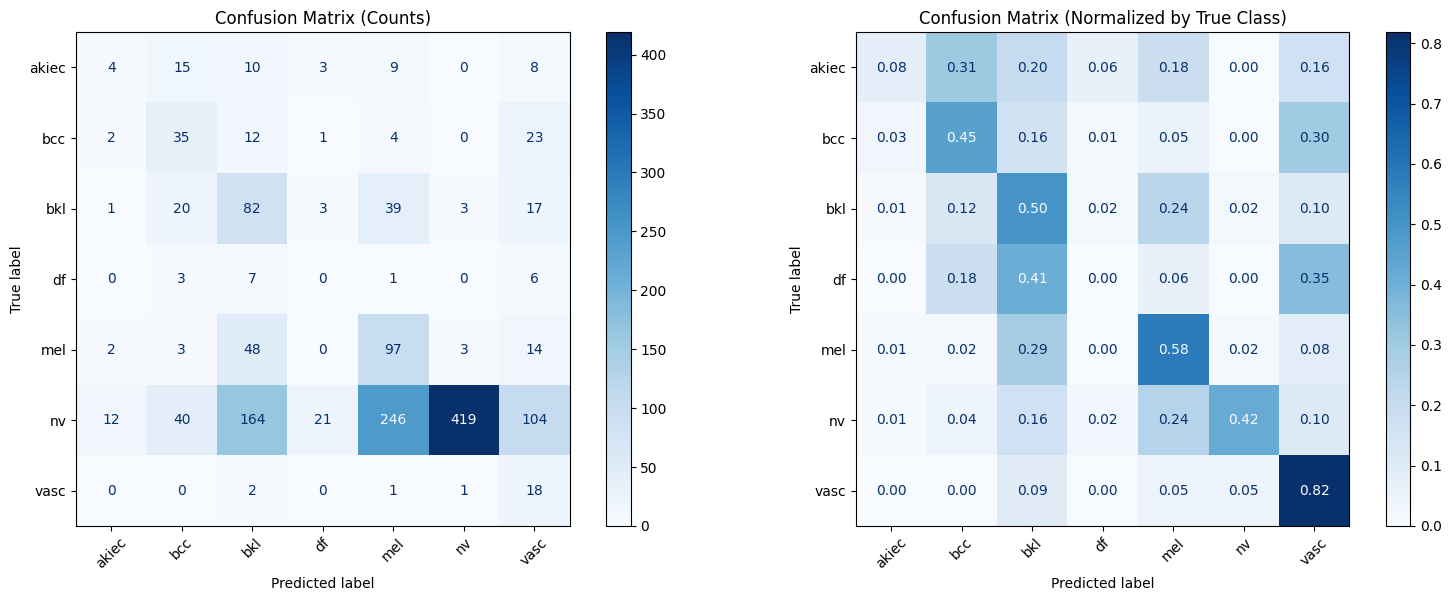

In [38]:
# -----------------------------------------------------------
# Confusion Matrix
# -----------------------------------------------------------
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
disp1 = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Confusion Matrix (Counts)')
axes[0].tick_params(axis='x', rotation=45)

# Normalized (percentage per true class)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
disp2 = ConfusionMatrixDisplay(cm_norm, display_labels=class_names)
disp2.plot(ax=axes[1], cmap='Blues', values_format='.2f')
axes[1].set_title('Confusion Matrix (Normalized by True Class)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [39]:
# -----------------------------------------------------------
# Classification Report
# Shows Precision, Recall, F1 for EACH of the 7 classes
# -----------------------------------------------------------
print('Classification Report')
print('=' * 65)
print(classification_report(y_test, y_pred, target_names=class_names))

print('Key metrics explained:')
print('  Precision = Of images predicted as class X, how many truly are X?')
print('  Recall    = Of all true class X images, how many did we find?')
print('  F1-Score  = Harmonic mean of Precision and Recall (balanced metric)')
print('  Support   = How many test images of this class')
print()
print('  macro avg    = Average across all classes (treats each class equally)')
print('  weighted avg = Average weighted by support (more weight to larger classes)')

Classification Report
              precision    recall  f1-score   support

       akiec       0.19      0.08      0.11        49
         bcc       0.30      0.45      0.36        77
         bkl       0.25      0.50      0.33       165
          df       0.00      0.00      0.00        17
         mel       0.24      0.58      0.34       167
          nv       0.98      0.42      0.59      1006
        vasc       0.09      0.82      0.17        22

    accuracy                           0.44      1503
   macro avg       0.30      0.41      0.27      1503
weighted avg       0.74      0.44      0.49      1503

Key metrics explained:
  Precision = Of images predicted as class X, how many truly are X?
  Recall    = Of all true class X images, how many did we find?
  F1-Score  = Harmonic mean of Precision and Recall (balanced metric)
  Support   = How many test images of this class

  macro avg    = Average across all classes (treats each class equally)
  weighted avg = Average weighted 

## 15. Per-Class Accuracy Analysis

Overall accuracy can be misleading with imbalanced data.
A model with 75% overall accuracy might have:
- 95% accuracy on `nv` (majority class)
- 5% accuracy on `df` (minority class)

We need to check accuracy **per class** to see if the model is actually learning all 7 classes.

Per-Class Accuracy
  akiec   :   4/ 49 correct =   8.2%
  bcc     :  35/ 77 correct =  45.5%
  bkl     :  82/165 correct =  49.7%
  df      :   0/ 17 correct =   0.0%
  mel     :  97/167 correct =  58.1%
  nv      : 419/1006 correct =  41.7%
  vasc    :  18/ 22 correct =  81.8%


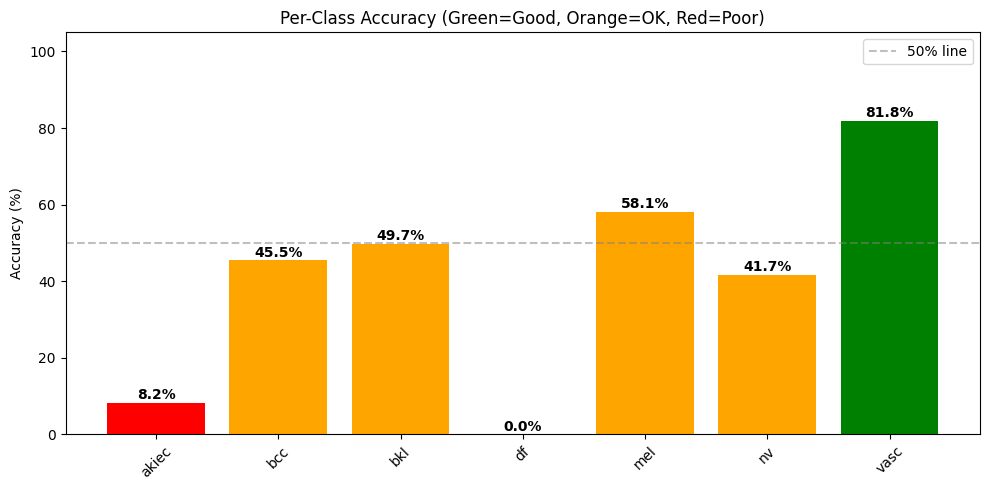

In [40]:
# -----------------------------------------------------------
# Calculate accuracy for each class separately
# -----------------------------------------------------------
print('Per-Class Accuracy')
print('=' * 55)

per_class_acc = []
for idx in range(num_classes):
    # Find all test images that truly belong to this class
    mask = (y_test == idx)
    total_in_class = mask.sum()

    if total_in_class == 0:
        per_class_acc.append(0)
        continue

    # Of those, how many did we predict correctly?
    correct = ((y_pred == idx) & mask).sum()
    acc = correct / total_in_class * 100
    per_class_acc.append(acc)

    print(f'  {class_names[idx]:8s}: {correct:3d}/{total_in_class:3d} correct = {acc:5.1f}%')

# -----------------------------------------------------------
# Visualize per-class accuracy as a bar chart
# -----------------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

bar_colors = []
for acc in per_class_acc:
    if acc >= 70:
        bar_colors.append('green')
    elif acc >= 40:
        bar_colors.append('orange')
    else:
        bar_colors.append('red')

bars = ax.bar(class_names, per_class_acc, color=bar_colors)
ax.set_ylabel('Accuracy (%)')
ax.set_title('Per-Class Accuracy (Green=Good, Orange=OK, Red=Poor)')
ax.set_ylim(0, 105)
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='50% line')
ax.tick_params(axis='x', rotation=45)

# Add percentage labels
for i in range(num_classes):
    ax.text(bars[i].get_x() + bars[i].get_width() / 2,
            bars[i].get_height() + 1,
            f'{per_class_acc[i]:.1f}%',
            ha='center', fontsize=10, fontweight='bold')

ax.legend()
plt.tight_layout()
plt.show()

## 16. Error Analysis

Look at misclassified images to understand:
- Which classes are confused with each other?
- Are the hard images genuinely ambiguous?
- Would higher resolution help?

Misclassified: 848 out of 1503
Error rate: 56.4%


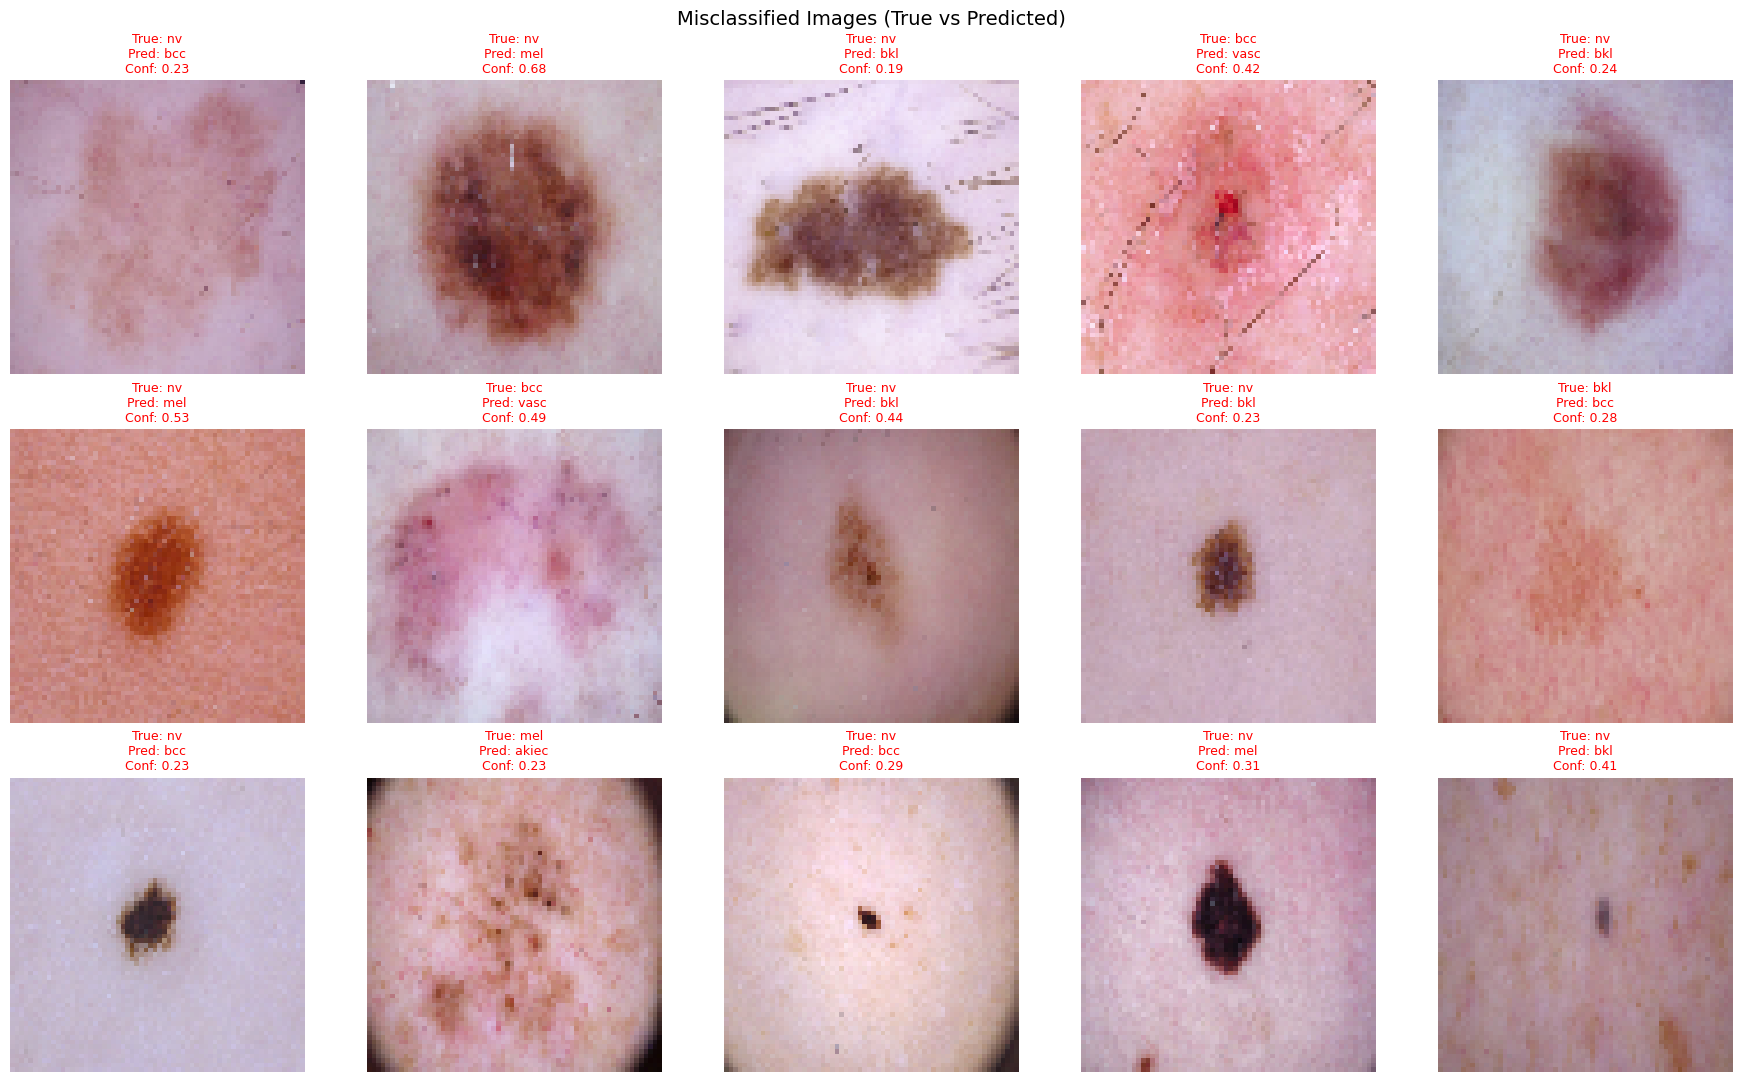

In [41]:
# -----------------------------------------------------------
# Display misclassified images
# -----------------------------------------------------------
wrong_indices = np.where(y_pred != y_test)[0]

print(f'Misclassified: {len(wrong_indices)} out of {len(y_test)}')
print(f'Error rate: {len(wrong_indices) / len(y_test) * 100:.1f}%')

# Show up to 15 misclassified images (3 rows x 5 columns)
num_show = min(15, len(wrong_indices))
fig, axes = plt.subplots(3, 5, figsize=(18, 11))

for i in range(num_show):
    row = i // 5
    col = i % 5
    idx = wrong_indices[i]

    axes[row, col].imshow(X_test[idx])
    axes[row, col].axis('off')

    true_label = class_names[y_test[idx]]
    pred_label = class_names[y_pred[idx]]
    confidence = y_pred_probs[idx][y_pred[idx]]    # confidence of predicted class

    axes[row, col].set_title(
        f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}',
        fontsize=9, color='red'
    )

# Hide unused subplots
for i in range(num_show, 15):
    row = i // 5
    col = i % 5
    axes[row, col].axis('off')

plt.suptitle('Misclassified Images (True vs Predicted)', fontsize=14)
plt.tight_layout()
plt.show()

In [42]:
# -----------------------------------------------------------
# Which class pairs are most commonly confused?
# -----------------------------------------------------------
print('Most Common Confusions (True -> Predicted):')
print('=' * 50)

# Count confusions from the confusion matrix
confusion_pairs = []
for true_idx in range(num_classes):
    for pred_idx in range(num_classes):
        if true_idx != pred_idx and cm[true_idx][pred_idx] > 0:
            confusion_pairs.append((
                class_names[true_idx],
                class_names[pred_idx],
                cm[true_idx][pred_idx]
            ))

# Sort by count (most confusions first)
confusion_pairs.sort(key=lambda x: x[2], reverse=True)

# Show top 10
for i in range(min(10, len(confusion_pairs))):
    true_name, pred_name, count = confusion_pairs[i]
    print(f'  {true_name:8s} misclassified as {pred_name:8s}: {count} times')

Most Common Confusions (True -> Predicted):
  nv       misclassified as mel     : 246 times
  nv       misclassified as bkl     : 164 times
  nv       misclassified as vasc    : 104 times
  mel      misclassified as bkl     : 48 times
  nv       misclassified as bcc     : 40 times
  bkl      misclassified as mel     : 39 times
  bcc      misclassified as vasc    : 23 times
  nv       misclassified as df      : 21 times
  bkl      misclassified as bcc     : 20 times
  bkl      misclassified as vasc    : 17 times


## 17. Conclusion

### What We Learned: Multi-Class Classification

| Concept | Binary (X-Ray) | Multi-Class (HAM10000) |
|---------|----------------|------------------------|
| Classes | 2 (Normal/Pneumonia) | 7 (skin lesion types) |
| Labels from | Folder names | CSV file |
| Output neurons | 1 (sigmoid) | 7 (softmax) |
| Loss function | `binary_crossentropy` | `sparse_categorical_crossentropy` |
| Prediction | threshold > 0.5 | `argmax` of 7 probabilities |
| Imbalance | 3:1 ratio | 58:1 ratio |
| Evaluation | Accuracy, single confusion matrix cell | Per-class accuracy, 7×7 confusion matrix |

### Key Takeaways

1. **Labels from CSV** — real datasets often store labels separately from images
2. **Softmax + sparse_categorical_crossentropy** — the standard combo for multi-class
3. **Class weights matter more** with extreme imbalance (58:1 vs 3:1)
4. **Per-class accuracy** reveals problems that overall accuracy hides
5. **Confusion matrix** shows which classes the model confuses with each other
6. **Some classes are genuinely hard** — even dermatologists disagree on some lesions

### What Could Improve Results Further?

| Technique | Expected Improvement |
|-----------|---------------------|
| Higher resolution (128×128 or 224×224) | Better detail for subtle patterns |
| Transfer learning (ResNet50, EfficientNet) | Pre-trained features from ImageNet |
| Oversampling minority classes (SMOTE for images) | More training examples for rare classes |
| Stronger augmentation (color jitter, elastic transforms) | More variety in training data |
| Ensemble of multiple models | Combines strengths of different architectures |